# import

In [93]:
# | code-fold : true

import pandas as pd
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst

warnings.filterwarnings(action = "ignore")

# 1. 데이터 로드

In [94]:
data = pd.read_csv("final_data.csv", encoding = "euc-kr")
#data.head()

# 2. 그룹화

`1` 최종 스코어 $y$를 기준으로 4개의 그룹으로 나누자

In [95]:
q1 = data["y"].describe()["25%"]
q2 = data["y"].describe()["50%"]
q3 = data["y"].describe()["75%"]

`3` 그룹 생성 

In [96]:
label = ["하위 그룹1", "하위 그룹2", "상위 그룹2", "상위 그룹1"]
bins = [-np.inf, q1,q2,q3, np.inf]

In [97]:
data["group"] = pd.cut(data["y"], bins= bins, labels = label)

In [98]:
data["group"].value_counts()

group
하위 그룹1    1364
하위 그룹2    1364
상위 그룹2    1364
상위 그룹1    1364
Name: count, dtype: int64

# 3. 변수들간 상관분석

In [99]:
data.replace(["유","무","시설없음"], [1,0,0], inplace = True) 
data.replace(["적정설치","단순설치","미설치"], [2,1,0], inplace = True)

In [100]:
cor_data = data.loc[:,"x1":"x30"].corr()
cor_data = cor_data.reset_index().\
                melt(id_vars = "index").\
                    sort_values("value")

cor_data = cor_data.loc[(cor_data["value"] >= abs(0.6)) & (cor_data["value"] < abs(1))]

In [101]:
cor_data.reset_index(drop=True,inplace = True)

In [102]:
cor_data = cor_data.loc[::2,:].rename(columns = {"index": "var1", 
                                      "variable" : "var2"})

In [103]:
cor_data["var"] = ["(" + i + ", " + j + ")"for i, j in zip(cor_data.var1,cor_data.var2)]

In [104]:
cor_data["color"] = ["red" if i > 0.7 else "blue" for i in cor_data["value"]]

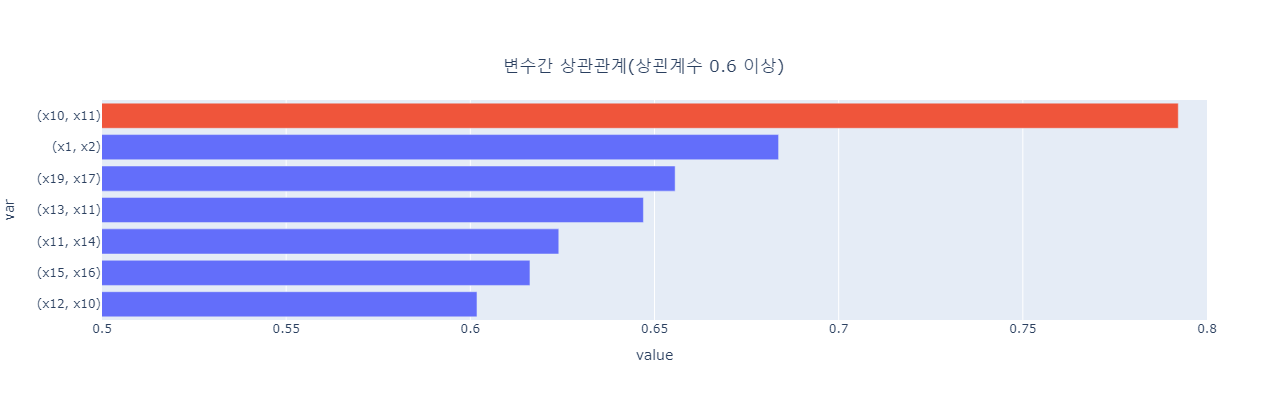

In [105]:
# | code-fold : true
fig = cor_data.plot(kind = "barh", backend = "plotly",
              y = "var", x = "value", color = "color",
                    width = 600, height = 400, title = "변수간 상관관계(상괸계수 0.6 이상)")

fig.update_layout(showlegend = False,
                  title_x = 0.5,
                  title_y = 0.85,
                 )

fig.update_xaxes(range = [0.5,0.8])

`1` 생활안전교육시간(x11)과 교통안전교육시간(x11)이 가장 연관성을 보였다.

`2` 또한, 장애인 편의시설 설치여부 변수간, 학교시설 개방여부 변수간에도 높은 연관성을 보이고 있다.

# 4. 그룹간 카테고리점수비교

## (1) anova 분석

In [106]:
f_col = ["s1","s2","s3","s4","y"]
group = ["하위 그룹1", "하위 그룹2", "상위 그룹2", "상위 그룹1"]

stats = []
pvalue = []
for i in range(len(f_col)) :
    for j in range(len(group)) :
        exec(f"g{j+1} = data.loc[data.group == group[{j}], f_col[{i}]]")
    result = spst.f_oneway(g1, g2, g3,g4)
    stats.append(result[0])
    pvalue.append(result[1])

In [107]:
result_table1 = pd.DataFrame({"var" : f_col, "statistics" : stats, "pvalue" : pvalue})

result_table1.to_csv("aonva분석.csv",index = False, encoding = "euc-kr")

In [108]:
result_table1

,var,statistics,pvalue
0,s1,3774.518867,0.000000e+00
1,s2,299.437768,5.994182e-180
2,s3,245.917642,1.144906e-149
3,s4,56.810704,3.727618e-36
4,y,7469.491297,0.000000e+00


### 시각화

In [109]:
g_data = data.groupby("group", as_index =  False).agg({"s1" : "mean",
                                              "s2" : "mean",
                                              "s3" : "mean",
                                              "s4" : "mean",
                                              "y" : "mean"})

In [110]:
g_data = g_data.melt(id_vars = "group").rename(columns = {"value" : "mean"})

In [111]:
fig = g_data.plot(backend = "plotly", kind = "bar",  x = "group", y = "mean",
             facet_col = "variable", color = "group",
              title = "학교평가 지표 그룹별 평균", facet_col_wrap = 3, width = 800, height = 600)

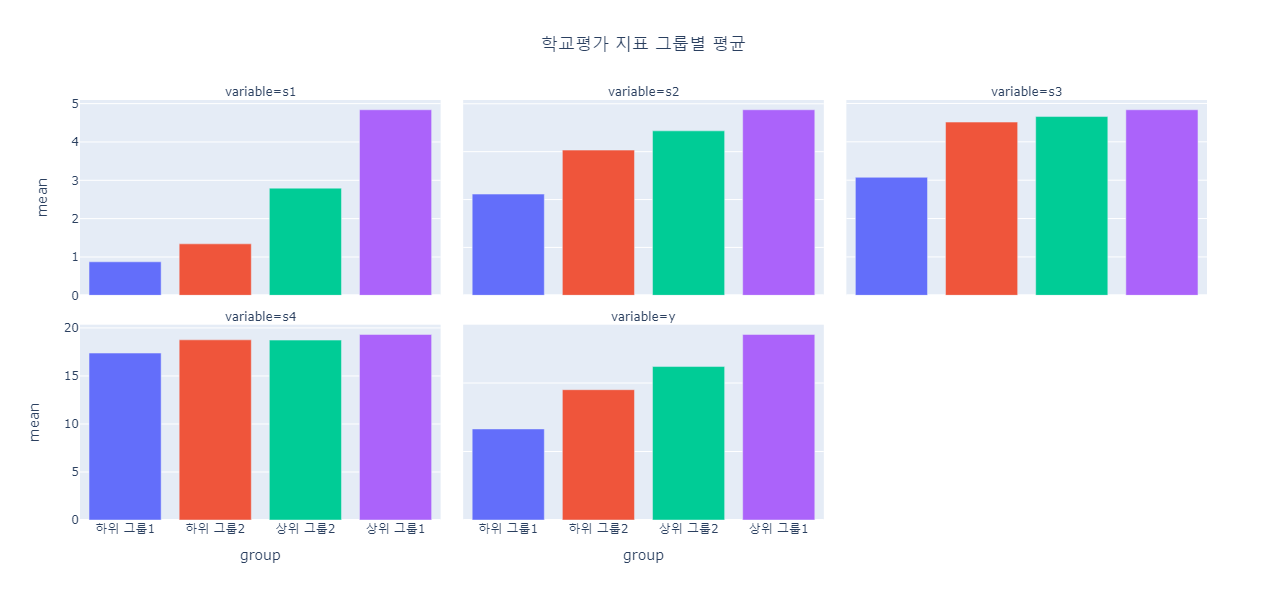

In [112]:
fig.update_layout(showlegend = False, title_x= 0.5)
fig.update_yaxes(matches = None)

## 어떤 카테고리가 가장 영향력이 있는지

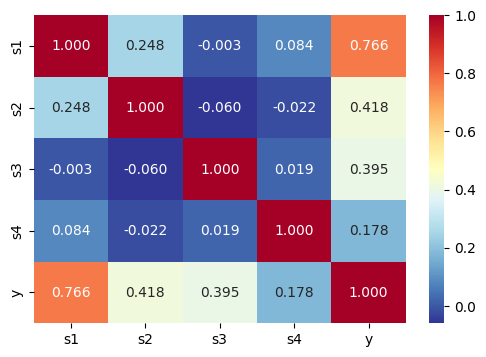

In [113]:
plt.figure(figsize = (6,4))
sns.heatmap(data[f_col].corr(),
            annot = True,
             fmt = ".3f",
             cmap = 'RdYlBu_r')
plt.show()